In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from models.vanilla import VanillaModel
from utils.utils import create_data_loaders, freq_to_image
from ext.training import ReconstructionTrainer
from ext.plot import plot_fit

%load_ext autoreload
%autoreload 2

In [ ]:
print(args.device)
print(torch.cuda.is_available())

cpu
False


In [2]:
from argparse import Namespace
args = {
    "seed" : 0,
    "data_path" : '/storage/downloads/fastmri_knee/',
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size" : 16,
    "num_workers" : 1,
    "num_epochs" : 10,
    "report_interval" : 1,
    "drop_rate" : .8,
    "learn_mask" : False,
    "results_root" : 'results',
    "lr" : 1e-2,
    "mask_lr" : 1e-2,
    "val_test_split" : .3,
}

args = Namespace(**args)

In [3]:

train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders

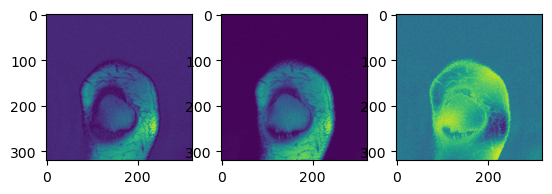

In [4]:
from utils.utils import freq_to_image
x, y = train_loader.dataset[0]
res = freq_to_image(x.unsqueeze(0))
plt.subplot(1, 3, 1)
plt.imshow(res[0])
plt.subplot(1, 3, 2)
plt.imshow(y)
plt.subplot(1, 3, 3)
plt.imshow(y - res[0])

diff = 4.3250364758244514e-06


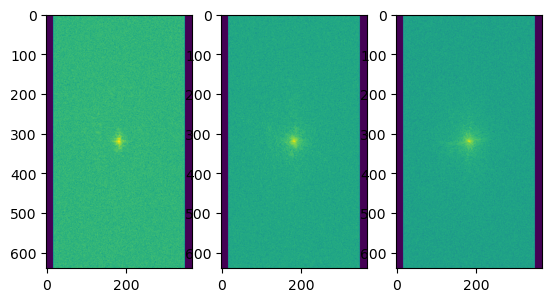

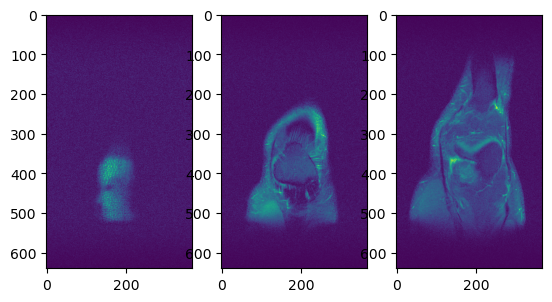

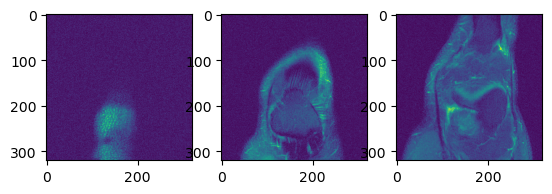

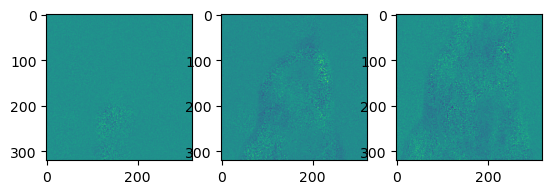

In [10]:
import h5py
from pathlib import Path
from data.transforms import complex_center_crop

def inverse_fft2_shift(kspace):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(-2,-1)), norm='ortho'),axes=(-2,-1))

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

hf = h5py.File(Path(args.data_path) / "singlecoil_train/file1002518.h5")

volume_kspace = hf['kspace'][()]
reconstruction = hf['reconstruction_esc'][()]

# Show in kspace domain
show_coils(np.log(np.abs(volume_kspace) + 1e-9), [0, 5, 10])

# Show in image domain
show_coils(np.abs(inverse_fft2_shift(volume_kspace)), [0, 5, 10])

# Show reconstruction (unattainable)
show_coils(reconstruction, [0, 5, 10])

# Show diff between reconstruction and volume_kspace
inverse = inverse_fft2_shift(volume_kspace)

# Extract real and imaginary parts
real_part = torch.tensor(inverse.real)
imaginary_part = torch.tensor(inverse.imag)

# Stack real and imaginary parts along the last dimension
inverse = torch.stack((real_part, imaginary_part), dim=-1)

cropped = complex_center_crop(inverse, (320, 320))
cropped = torch.view_as_complex(cropped)
show_coils(torch.tensor(reconstruction) - np.abs(cropped), [0, 5, 10])
# print sum of diff
print("diff =", torch.sum(torch.abs(torch.tensor(reconstruction) - np.abs(cropped))).item())


diff = 130506.76298212279


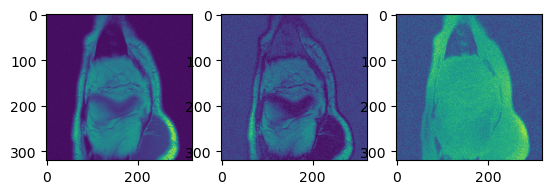

In [17]:
# Manual reconstruction after dataloader normalization

x, y = train_loader.dataset[420]
complex = torch.view_as_complex(x)
our_img = np.abs(inverse_fft2_shift(complex.numpy()))
# plot y and our_img and diff
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(y)
plt.subplot(1,3,2)
plt.imshow(our_img)
plt.subplot(1,3,3)
plt.imshow(y - our_img)
print("diff =", torch.sum(torch.abs(y - our_img)).item())


39537.37109375


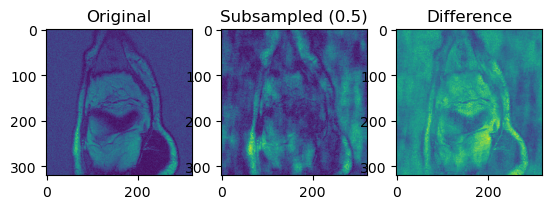

In [15]:
from models.subsampling import SubsamplingLayer

drop_rate = .5
subsample = SubsamplingLayer(drop_rate, args.device, args.learn_mask) #initialize subsampling layer - use this in your own model
x, _ = train_loader.dataset[420]
img_orig = freq_to_image(x.unsqueeze(0))
new_x = subsample(x.unsqueeze(0))[0]
fig = plt.figure()
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_orig[0])
plt.subplot(1,3,2)
plt.title(f"Subsampled ({drop_rate})")
plt.imshow(new_x[0])
plt.subplot(1,3,3)
plt.title("Difference")
diff = img_orig[0] - new_x[0]
plt.imshow(diff)
# print if there's any difference
print(torch.sum(diff).item())


In [13]:
# Vanilla Training
train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders

args.num_epochs = 50
model = VanillaModel(args.drop_rate, args.device, args.learn_mask).to(args.device) #Example instatiation - replace with your model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) #initialize optimizer
loss_fn = torch.nn.MSELoss() #initialize loss function
trainer = ReconstructionTrainer(model, loss_fn, optimizer, args.device) #initialize trainer
fit_res = trainer.fit(train_loader, test_loader, num_epochs=args.num_epochs, print_every=args.report_interval, verbose=True)
plot_fit(fit_res)


--- EPOCH 1/50 ---


train_batch:   0%|          | 0/869 [00:00<?, ?it/s]

KeyboardInterrupt: 

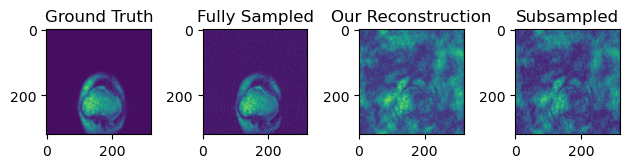

In [ ]:
from utils.utils import plot_results
x, y = test_loader.dataset[0]
model.reconstruct = model.conv
plot_results(model, x, y)

In [ ]:
import pickle
with open('/storage/model_50.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle
with open('/storage/model_50.pkl', 'rb') as f:
    model = pickle.load(f)

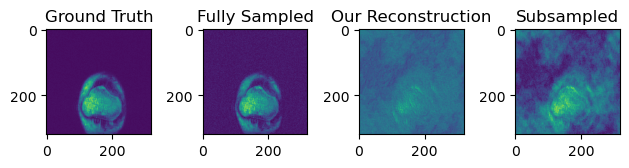

In [18]:
from utils.utils import plot_results
from models.unet_rec import UNet_Rec

#Test UNet_Rec without training
x, y = test_loader.dataset[0]
model = UNet_Rec(args.drop_rate, args.device, args.learn_mask)
plot_results(model, x, y, args.device)

In [19]:
train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders

# UNet_Rec Training
args.num_epochs = 2
model = UNet_Rec(0.3, args.device, args.learn_mask).to(args.device) #Example instatiation - replace with your model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) #initialize optimizer
loss_fn = torch.nn.MSELoss() #initialize loss function
trainer = ReconstructionTrainer(model, loss_fn, optimizer, args.device) #initialize trainer
fit_res = trainer.fit(train_loader, test_loader, num_epochs=args.num_epochs, print_every=args.report_interval, verbose=True)
plot_fit(fit_res)


--- EPOCH 1/2 ---


train_batch:   0%|          | 0/869 [00:00<?, ?it/s]

/home/arad/.conda/envs/project/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 320, 320])) that is different to the input size (torch.Size([16, 1, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 